In [1]:
#! pip install --user tslearn matplotlib

import os
## TODO change to 0
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import sys
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.getcwd())

import random
import numpy
import numpy as np
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
import torch
from torch import nn, optim

from src.learning_shapelets import LearningShapelets

In [2]:
def normalize_standard(X, scaler=None):
    shape = X.shape
    data_flat = X.flatten()
    if scaler is None:
        scaler = StandardScaler()
        data_transformed = scaler.fit_transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    else:
        data_transformed = scaler.transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    return data_transformed, scaler

def normalize_data(X, scaler=None):
    if scaler is None:
        X, scaler = normalize_standard(X)
    else:
        X, scaler = normalize_standard(X, scaler)
    
    return X, scaler

def sample_ts_segments(X, shapelets_size, n_segments=10000):
    """
    Sample time series segments for k-Means.
    """
    n_ts, n_channels, len_ts = X.shape
    samples_i = random.choices(range(n_ts), k=n_segments)
    segments = numpy.empty((n_segments, n_channels, shapelets_size))
    for i, k in enumerate(samples_i):
        s = random.randint(0, len_ts - shapelets_size)
        segments[i] = X[k, :, s:s+shapelets_size]
    return segments

def get_weights_via_kmeans(X, shapelets_size, num_shapelets, n_segments=10000):
    """
    Get weights via k-Means for a block of shapelets.
    """
    segments = sample_ts_segments(X, shapelets_size, n_segments).transpose(0, 2, 1)
    k_means = TimeSeriesKMeans(n_clusters=num_shapelets, metric="euclidean", max_iter=50).fit(segments)
    clusters = k_means.cluster_centers_.transpose(0, 2, 1)
    return clusters

In [3]:
dataset = "FaceFour"
# Load training data
X_train = numpy.load(open(os.path.join('data', f'{dataset}_train.npy'), 'rb'))
X_train_size = X_train.shape[0]
print(f"Shape X_train: {X_train.shape}")
# load trainng data labels
y_train = numpy.load(open(os.path.join('data', f'{dataset}_train_labels.npy'), 'rb'))
# normalize training data
X_train, scaler = normalize_data(X_train)

Shape X_train: (24, 1, 350)


In [66]:
n_ts, n_channels, len_ts = X_train.shape
loss_func = nn.CrossEntropyLoss()
num_classes = len(set(y_train))
# learn 48 shapelets
shapelets_size_and_len = {40:35, 80:16, 120:8 }
dist_measure = "euclidean"
lr = 4e-3
wd = 1e-4
epsilon = 1e-7
batch_size = 256
shuffle = True
drop_last = False


In [67]:
shapelets_blocks = []
for i, (shapelets_size, num_shapelets) in enumerate(shapelets_size_and_len.items()):
    weights_block = get_weights_via_kmeans(X_train, shapelets_size, num_shapelets)
    shapelets_blocks.append(weights_block)

In [68]:
l1 = 0.05
l2 = 0.15
k = int(0.1 * batch_size) if batch_size <= X_train_size else X_train_size


learning_shapelets_Lr = LearningShapelets(shapelets_size_and_len=shapelets_size_and_len,
                                       in_channels=n_channels,
                                       num_classes=num_classes,
                                       loss_func=loss_func,
                                       to_cuda=False,
                                       verbose=1,
                                       dist_measure=dist_measure,
                                       l1=l1,
                                       l2=l2,
                                       k=k)

In [69]:
for i, shapelets_block in enumerate(shapelets_blocks):
    learning_shapelets_Lr.set_shapelet_weights_of_block(i, shapelets_block)

In [70]:
optimizer = optim.Adam(learning_shapelets_Lr.model.parameters(), lr=lr, eps=epsilon)
learning_shapelets_Lr.set_optimizer(optimizer)

In [71]:
def eval_accuracy(model, X, Y):
    predictions = model.predict(X)
    if len(predictions.shape) == 2:
        predictions = predictions.argmax(axis=1)
        print(predictions)
    print(f"Accuracy: {(predictions == Y).sum() / Y.size}")
    return (predictions == Y).sum() / Y.size

In [72]:
epochs = 200
n_epoch_steps = 5
losses = []
train_acc_last = 0

losses_acc = []
losses_dist = []
losses_sim = []
train_acc_last_Lr = 0
for _ in range(n_epoch_steps):
    losses_acc_i, losses_dist_i, losses_sim_i = \
        learning_shapelets_Lr.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                  shuffle=shuffle, drop_last=drop_last)
    losses_acc += losses_acc_i

    losses_dist += losses_dist_i
    losses_sim += losses_sim_i
    train_acc_current_Lr = eval_accuracy(learning_shapelets_Lr, X_train, y_train)
    if train_acc_current_Lr - train_acc_last_Lr < 1e-3 or train_acc_current_Lr == 1.0:
        break
    train_acc_last_Lr = train_acc_current_Lr

Loss CE: 0.009313917718827724, Loss dist: 0.211456760764122, Loss sim: 0.0016603909898549318: 100%|██████████████| 200/200 [00:07<00:00, 25.23it/s]

[1 1 0 0 1 3 3 3 0 0 3 1 0 1 2 1 2 1 2 0 3 0 1 0]
Accuracy: 1.0


In [74]:
# Load data set
X_test = numpy.load(open(os.path.join('data', f'{dataset}_test.npy'), 'rb'))
print(f"Shape X_train: {X_test.shape}")
y_test = numpy.load(open(os.path.join('data', f'{dataset}_test_labels.npy'), 'rb'))
# normalize data
X_train, scaler = normalize_data(X_train, scaler)
test_acc = eval_accuracy(learning_shapelets_Lr, X_test, y_test)
print(test_acc)

Shape X_train: (88, 1, 350)
[2 0 1 3 0 3 2 2 1 2 0 2 1 1 1 1 1 2 1 3 0 1 1 0 1 3 2 1 2 3 3 1 2 3 3 3 0
 2 1 1 1 2 2 3 0 1 2 2 3 0 3 1 1 2 3 3 3 2 2 1 1 1 3 1 2 1 3 1 0 3 2 2 1 0
 0 0 1 1 2 1 2 0 3 3 0 3 1 3]
Accuracy: 0.9318181818181818
0.9318181818181818


In [12]:
X_test = numpy.load(open(os.path.join('data', f'{dataset}_test.npy'), 'rb'))
print(f"Shape X_train: {X_test.shape}")
y_test = numpy.load(open(os.path.join('data', f'{dataset}_test_labels.npy'), 'rb'))
# normalize data
X_train, scaler = normalize_data(X_train, scaler)

Shape X_train: (88, 1, 350)


In [49]:
save_shapelets = learning_shapelets_Lr.get_shapelets()
numpy.save('shapelets_Lr_3d_FF.npy', save_shapelets)
shapelets_Lr = numpy.load("shapelets_Lr_3d_FF.npy")
n_shapelets_Lr = shapelets_Lr.shape[0]
n_shapelets = shapelets_Lr.shape[0]

# ANALYSIS

In [14]:
def filterNanFromShapelet(shapelet):
    """
    Filter NaN values from a shapelet.
    Needed for the output of learning shapelets from tslearn, since smaller size shapelets are padded with NaN values.
    Note: Make sure the NaN values are only leading or trailing.
    """
    return shapelet[~numpy.isnan(shapelet)]

def lead_pad_shapelet(shapelet, pos):
    """
    Adding leading NaN values to shapelet to plot it on a time series at the best matching position.
    """
    pad = numpy.empty(pos)
    pad[:] = numpy.NaN
    padded_shapelet = numpy.concatenate([pad, filterNanFromShapelet(shapelet)])
    return padded_shapelet

def torch_dist_ts_shapelet(ts, shapelet, to_cuda=True):
    """
    Use PyTorch to calculate the distance between a shapelet and a time series.
    Implemented via unfolding.
    """
    if not isinstance(ts, torch.Tensor):
        ts = torch.tensor(ts, dtype=torch.float)
    if not isinstance(shapelet, torch.Tensor):
        shapelet = torch.tensor(shapelet, dtype=torch.float)
    if to_cuda:
        ts = ts.cuda()
        shapelet = shapelet.cuda()
    if shapelet.dim() == 1:
        shapelet = torch.unsqueeze(shapelet, 0)
    # unfold time series to emulate sliding window
    ts = ts.unfold(1, shapelet.shape[1], 1)
    # calculate euclidean distance over each segment
    dists = torch.sum(torch.cdist(ts, shapelet, p=2), dim=0)
    # filter min dist
    d_min, d_argmin = torch.min(dists, 0)
    return (d_min.item(), d_argmin.item())

def dists_to_shapelet(data, shapelet, to_cuda=True):
    """
    Calculate the distances of a shapelet to a bunch of time series.
    """
    shapelet = filterNanFromShapelet(shapelet)
    dists = []
    for i in range(len(data)):
        dists.append((torch_dist_ts_shapelet(data[i,:], shapelet, to_cuda=to_cuda), i))
    return sorted(dists, key=lambda x: x[0][0])



def plot_shapelet_on_ts_at_i(shapelet, ts, i, title="", axis=None):
    """
    Plot a shapelet on top of a timeseries
    """
    shapelet = filterNanFromShapelet(shapelet)
    padded_shapelet = lead_pad_shapelet(shapelet, i)
    if axis is None:
        pyplot.clf()
        pyplot.rcParams["figure.figsize"] = (23, 6)
        pyplot.plot(ts)
        pyplot.plot(padded_shapelet)
    else:
        axis.plot(ts)
        axis.plot(padded_shapelet)
        
#CUSTOM:

def dists_ts_to_shapelets(ts, shapelets, to_cuda=False):
    """
    Calculate the distances of shapelets to a timeseries
    """
    dists = []
    for i in range(len(shapelets)):
        shapelet = filterNanFromShapelet(shapelets[i])
        dists.append((torch_dist_ts_shapelet(ts, shapelet, to_cuda=to_cuda),i))
    return sorted(dists, key=lambda x: x[0][0])

def plot_ts_and_shapelet(ts,shapelet): 
    sh = filterNanFromShapelet(shapelet)
    dist, pos = torch_dist_ts_shapelet(ts,sh,to_cuda=False)
    padded_shapelet = lead_pad_shapelet(sh,pos)
    pyplot.plot(ts.flatten())
    pyplot.plot(padded_shapelet)
    pyplot.show()


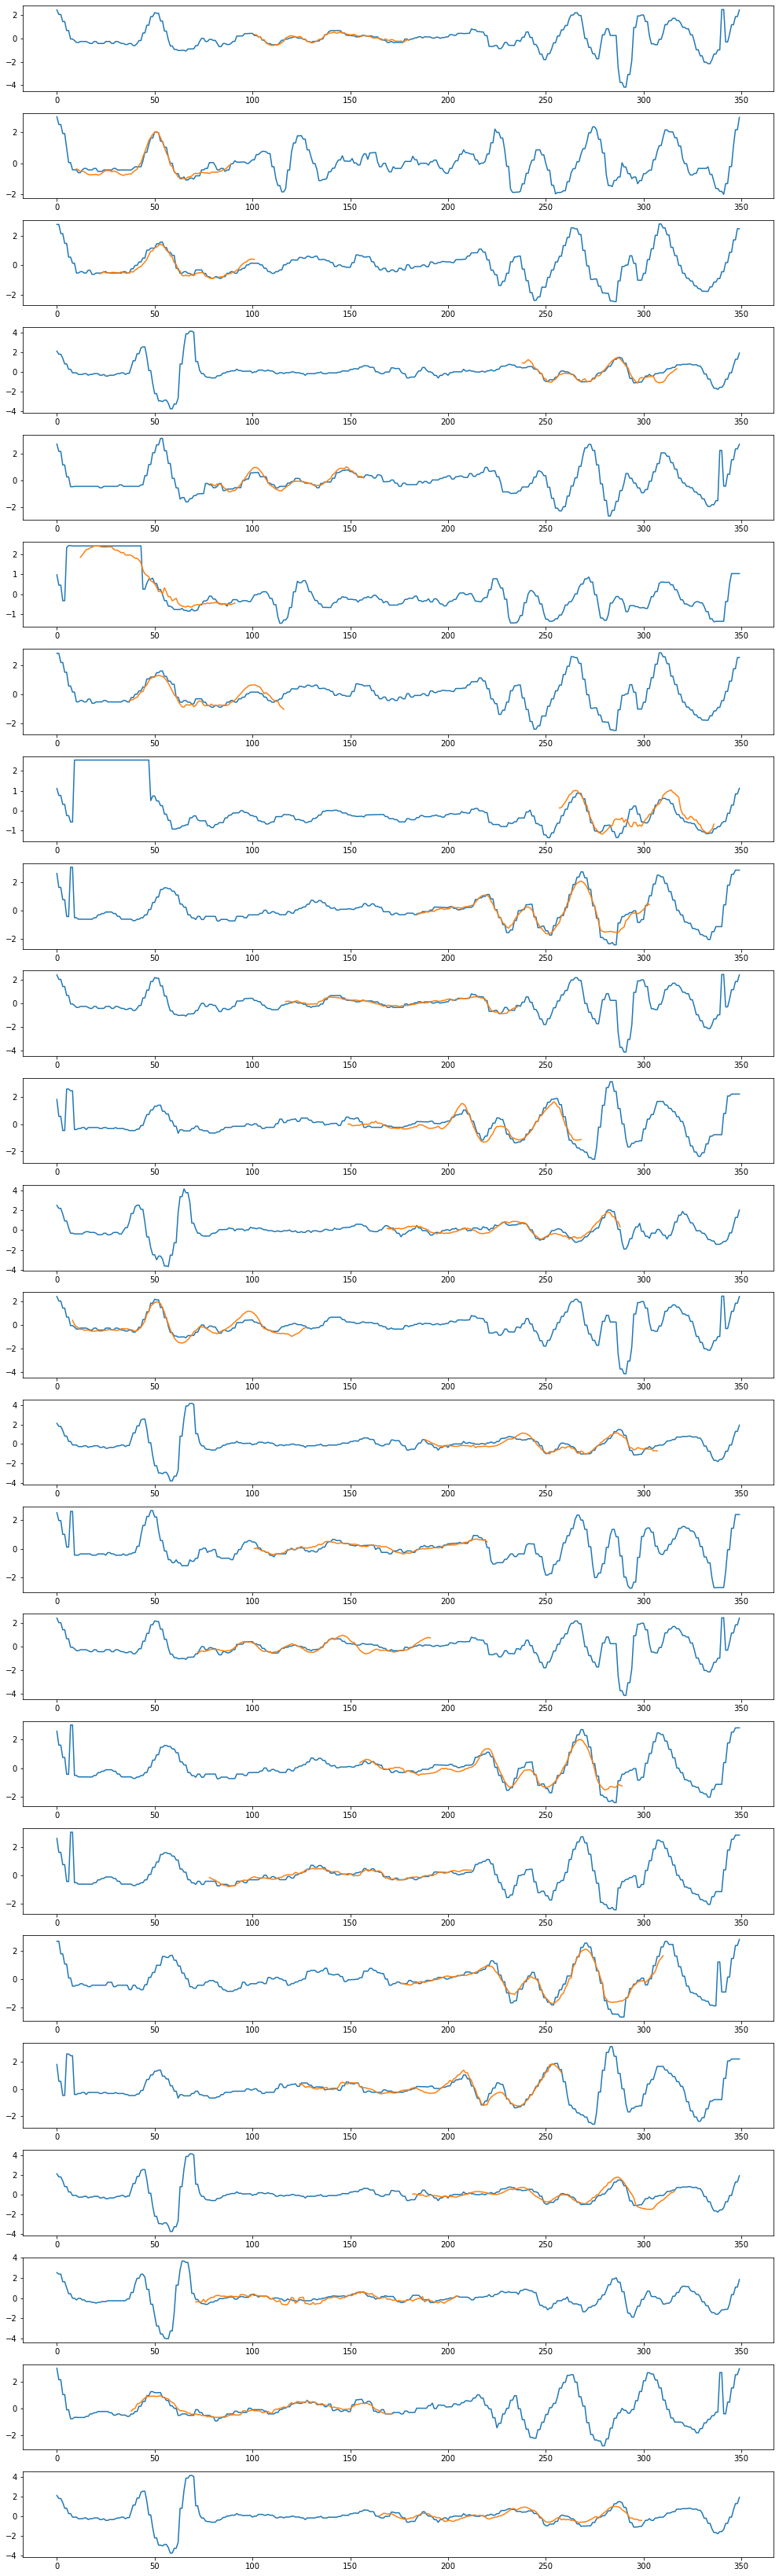

In [75]:
fig, axes = pyplot.subplots(n_shapelets, 1)
pyplot.rcParams['axes.facecolor'] = 'white'
pyplot.rcParams['savefig.facecolor']='white'
#fig.suptitle(f'Learned Shapelets\nDataset: {dataset}\nLeft: Learning Shapelets (Acc: {test_acc}%, {n_shapelets_ce} Shapelets)\nRight: This work (Acc: {test_acc_Lr}%, {n_shapelets_Lr} Shapelets)')
fig.set_size_inches(14, 2 * n_shapelets)

relative_distances_gra = []
relative_distances_contrastive = []
for i in range(n_shapelets):
    if i < n_shapelets_Lr:
        shapelet_Lr = filterNanFromShapelet(shapelets_Lr[i, 0])
        best_match_Lr = dists_to_shapelet(X_test, shapelet_Lr, to_cuda=False)[0]
        plot_shapelet_on_ts_at_i(shapelet_Lr, X_test[best_match_Lr[1], 0], best_match_Lr[0][1], axis=axes[i])
pyplot.tight_layout(rect=[0, 0.03, 1, 0.98])
pyplot.show()

In [24]:
import numpy as np
import pandas as pd

def find_ts_per_class(y_test, searched_class): 
    normal_sort = np.sort(y_test)
    arg_sort = np.argsort(y_test)
    class_x = arg_sort[np.where(normal_sort==searched_class)]
    return class_x

def get_best_explanations_per_class(number,y):
    normal_sort = np.sort(y)
    arg_sort = np.argsort(y)
    #For each class
    explanations_per_class = dict()
    for i in set(y):
        explanations_per_class[i] = list()
        ts_per_class = arg_sort[np.where(normal_sort==i)]
        for ts in ts_per_class: 
            explanations = dists_ts_to_shapelets(X_test[ts],shapelets_Lr)[:number]
            explanations_per_class[i].append(*explanations) #[for single values *explnations]
    return explanations_per_class

best_exp = get_best_explanations_per_class(1,y_train)
print(best_exp)

{0: [((1.6896600723266602, 62), 4), ((4.417928695678711, 4), 3), ((5.181896686553955, 98), 0), ((4.561367988586426, 73), 7), ((4.099871635437012, 75), 4), ((4.717580795288086, 5), 3), ((3.7749218940734863, 170), 2), ((4.4340996742248535, 99), 0)], 1: [((4.035995960235596, 86), 7), ((5.29850959777832, 208), 5), ((5.75047492980957, 5), 3), ((4.0201239585876465, 93), 7), ((1.7089229822158813, 62), 4), ((2.018151044845581, 67), 4), ((4.510457992553711, 5), 3), ((3.858827829360962, 171), 2)], 2: [((4.392581939697266, 124), 0), ((4.636780261993408, 98), 0), ((6.3082804679870605, 110), 0)], 3: [((1.875542402267456, 65), 4), ((3.8183250427246094, 173), 2), ((4.56667423248291, 83), 7), ((4.1310505867004395, 13), 6), ((1.8466182947158813, 63), 4)]}


In [143]:
def get_stats_for_explanations_per_class(X,y):
    normal_sort = np.sort(y)
    arg_sort = np.argsort(y)
    #For each class
    explanations_per_class = dict()
    for i in set(y):
        explanations_per_class[i] = list()
        ts_per_class = arg_sort[np.where(normal_sort==i)]
        for ts in ts_per_class: 
            explanations = dists_ts_to_shapelets(X[ts],shapelets_Lr)
            sort_by_shapeletnr = [(x[0][0]) for x in sorted(explanations, key = lambda x: x[1])]
            #print(sort_by_shapeletnr)
            #print(sorted(explanations, key = lambda x: x[1]))
            explanations_per_class[i].append(sort_by_shapeletnr) #[for single values *explnations]
    return explanations_per_class

best_exp0 = get_stats_for_explanations_per_class(X_train,y_train)
best_exp1 = get_stats_for_explanations_per_class(X_test,y_test)

def make_pretty(styler):
    styler.set_caption("Distances to Shapelets")
    #styler.format(rain_condition)
    #styler.format_index(lambda v: v.strftime("%A"))
    styler.background_gradient(axis=None, vmin=1, vmax=5, cmap="RdPu")
    return styler


pd.DataFrame(best_exp0[0]).transpose().style.pipe(make_pretty)
pd.DataFrame(best_exp1[0]).transpose().style.pipe(make_pretty)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,3.386600,3.042174,2.850110,2.630656,3.224267,2.778724,3.249565,3.214958,3.108977,3.476671,3.378473,3.182205,2.957703,3.024687
1,3.186211,2.989450,2.879168,3.311956,2.947267,3.030683,2.898186,3.292966,3.402635,3.369646,3.017967,2.865244,3.079185,2.696819
2,2.217500,2.902922,2.316887,2.676060,2.660383,2.137547,2.577316,2.241600,2.309392,2.462043,1.800582,2.478098,2.238856,2.168851
3,4.922503,5.254443,5.929278,5.436927,5.728724,5.060805,4.537467,4.929779,4.390541,5.742292,4.824761,5.849101,5.127463,5.634223
4,3.754503,4.057953,4.283454,3.741683,3.545120,4.131980,3.853174,3.707797,3.674144,3.975183,3.694899,3.683764,4.126074,3.976230
5,10.998643,10.848487,11.011127,11.519859,10.901410,11.517993,11.150788,11.302227,11.173711,10.709936,10.918003,10.965025,11.282513,11.256582
6,2.784002,3.443055,3.215518,3.838238,3.346910,3.567415,3.079029,3.050625,3.042820,3.091741,2.782668,3.021940,3.488102,3.020968
7,4.811397,5.756739,5.573885,5.241681,5.524904,5.359506,5.202278,5.269536,4.840259,5.504609,5.351126,5.551917,5.669888,5.255527
8,5.083104,4.536967,3.804496,4.481510,4.023331,8.643817,4.344542,4.483120,4.674788,5.854370,5.004147,5.154608,4.624327,4.004888
9,4.742448,3.794996,3.439762,4.125365,3.933504,3.359258,3.985677,4.053743,4.685252,4.423920,3.899311,4.107937,4.032337,3.568223


In [145]:
test_df = pd.DataFrame()
for i in best_exp1: 
    test_df[i] = np.zeros(20)
    for j in best_exp1: 
        if i == j: continue
        test_df[i] += pd.DataFrame(best_exp1[i]).transpose().mean(axis=1)#-pd.DataFrame(best_exp1[j]).transpose().mean(axis=1)


#test_df0 =test_df
test_df1 = test_df

In [146]:
print(test_df1 == test_df0)

       0     1     2     3
0   True  True  True  True
1   True  True  True  True
2   True  True  True  True
3   True  True  True  True
4   True  True  True  True
5   True  True  True  True
6   True  True  True  True
7   True  True  True  True
8   True  True  True  True
9   True  True  True  True
10  True  True  True  True
11  True  True  True  True
12  True  True  True  True
13  True  True  True  True
14  True  True  True  True
15  True  True  True  True
16  True  True  True  True
17  True  True  True  True
18  True  True  True  True
19  True  True  True  True


In [21]:
pd.DataFrame(best_exp1[0]).describe().transpose().sort_values("mean")

,count,mean,std,min,25%,50%,75%,max
4,8.0,1.846228,0.344382,1.233235,1.748504,1.846052,1.927168,2.484823
2,8.0,4.288139,0.758153,3.286573,3.845565,4.039632,4.865655,5.455668
0,8.0,5.125677,0.340197,4.447577,4.986298,5.195678,5.336186,5.537722
6,8.0,5.258272,0.551287,4.565466,4.876814,5.186573,5.519138,6.309639
7,8.0,6.348757,0.489145,5.851262,6.015260,6.156072,6.565952,7.203186
3,8.0,6.444646,0.511096,5.897863,6.200388,6.221316,6.554449,7.516221
5,8.0,7.661061,1.040496,5.712933,7.163643,7.831104,8.384139,8.856988
1,8.0,8.223509,0.825637,7.188890,7.852957,7.956186,8.374711,9.871000


In [96]:
#print(best_exp1)
#tst =pd.DataFrame(best_exp1[0]).transpose().style.pipe(make_pretty)#,columns=["Dist_Pos","Shapelet"]).groupby(["Shapelet"])
#dd = pd.DataFrame(best_exp1[3]).describe().transpose().sort_values("mean")

ll = []
print(set(y_test))
for i in set(y_test):
    c = 0
    nr = []
    dd = pd.DataFrame(best_exp1[i]).describe().transpose().sort_values("mean")
    for j in dd.iterrows():
        if c > 3:
            ll.append(nr)
            break;
        nr.append(j[0])
        c += 1
ll.append(nr)

print(ll)
#For x_test

{0, 1, 2, 3}
[[17, 2, 14, 22], [1, 2, 0, 4], [0, 14, 21, 9], [0, 4, 9, 14], [0, 4, 9, 14]]


In [97]:
xs = list(np.array(ll).flatten())
de = set([x for x in xs if xs.count(x) > 1])
print(de)
ll2 = []
for element in ll: 
    lh = []
    for item in element: 
        if item not in de:
            lh.append(item)
    ll2.append(lh)
    
print("BEST EXPLANATIONS PER CLASS",ll2)
# For x_test [[5, 14], [6, 13], [11, 9], [18, 2]]
# For x_train [[5], [6, 2], [11, 9], [18]]
# Best exp both: [[5], [6], [11, 9], [18]]

{0, 2, 4, 9, 14}
BEST EXPLANATIONS PER CLASS [[17, 22], [1], [21], [], []]


In [296]:
%%time
import matplotlib.pyplot as plt
def find_most_frequent_shapelets(best_explnations, y_class, top_n): 
    gpd =pd.DataFrame(best_explnations[y_class],columns=["Dist_Pos","Shapelet"]).groupby(["Shapelet"])
    most_frequent = gpd.describe().sort_values(('Dist_Pos',  'count'), ascending=False)[:top_n]
    return most_frequent


def plot_class_and_shapelets(y_class, ts_per_class, X_val,shp):
    pyplot.rcParams["figure.figsize"] = (20,8)
    pyplot.title(f"Best Explanations for class {y_class}")
    for ts in ts_per_class:
        pyplot.plot(X_val[ts].flatten(), color="grey", alpha=0.1)
    
    for sp in shp.iterrows(): 

        shp_n = sp[0]
        shp_n = shapelets_Lr[shp_n]
        shp_n = filterNanFromShapelet(shp_n)
        
        shp_pos_n = sp[1][2][1]
        
        shp_freq = sp[1][1]
        shp_avg_class_dist = sp[1][2][0] 
        
        padded_shapelet = lead_pad_shapelet(shp_n,shp_pos_n)
        pyplot.plot(padded_shapelet, label=f"shp_n: {sp[0]} Frequency: {shp_freq} | Avg Dist: {shp_avg_class_dist}", linewidth=3)
        plt.legend(loc="upper left")
    pyplot.show()
    

yclass_n = 2
exp_per_ts = 1
def plot_shapelets_for_classes(best_exp,n_exp,yclasses):
    for yclass_n in yclasses: 
        most_frq = find_most_frequent_shapelets(best_exp,yclass_n,n_exp) 
        cl = find_ts_per_class(y_test,yclass_n)
        plot_class_and_shapelets(yclass_n, cl, X_test,most_frq)
    
#plot_shapelets_for_classes(best_exp,2, set(y_test))
print(len(y_test))

88
Wall time: 0 ns


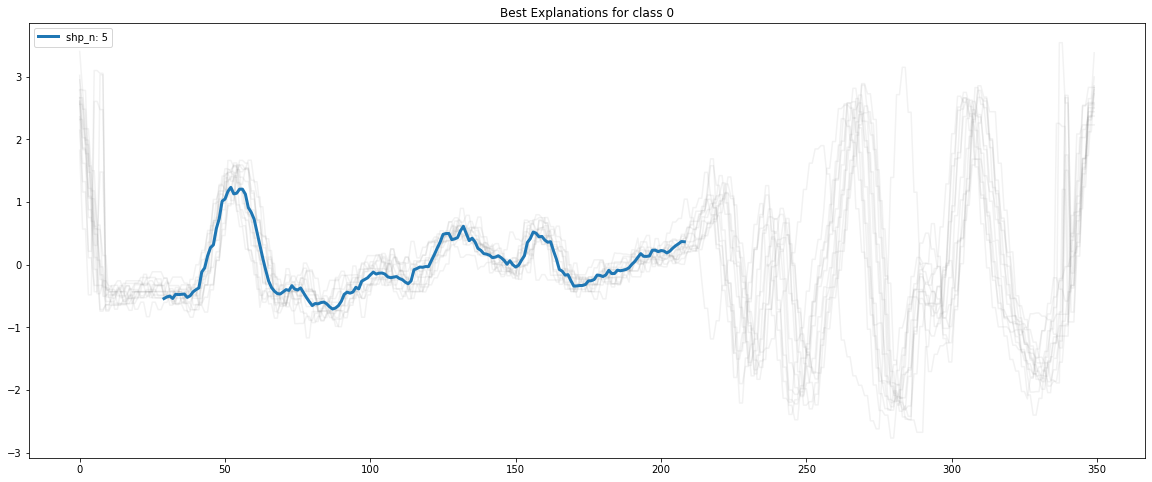

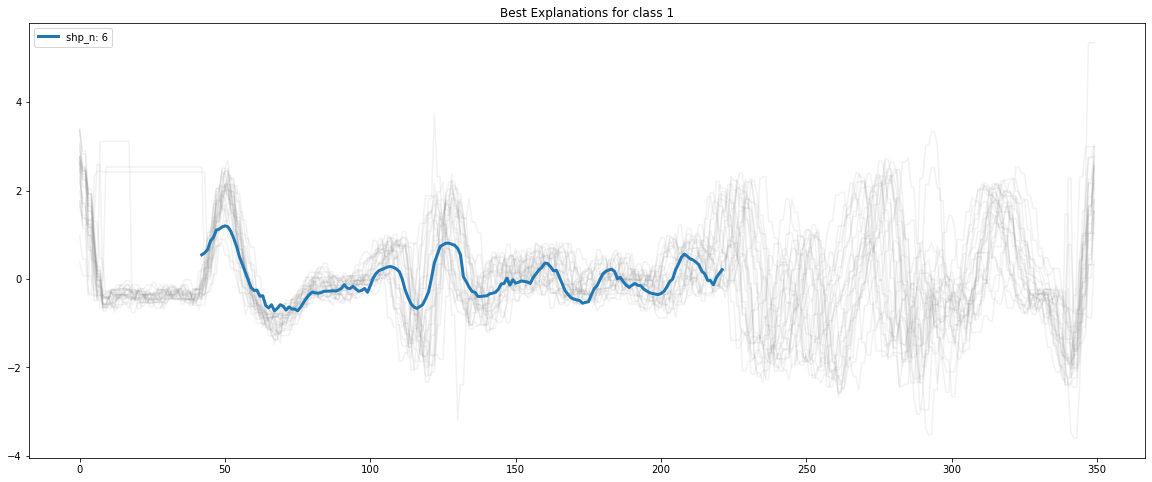

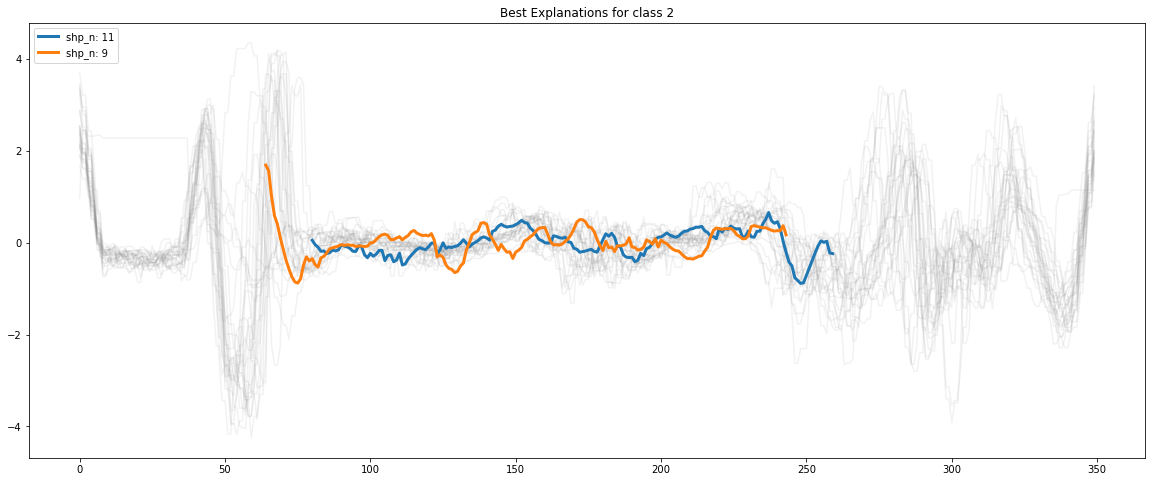

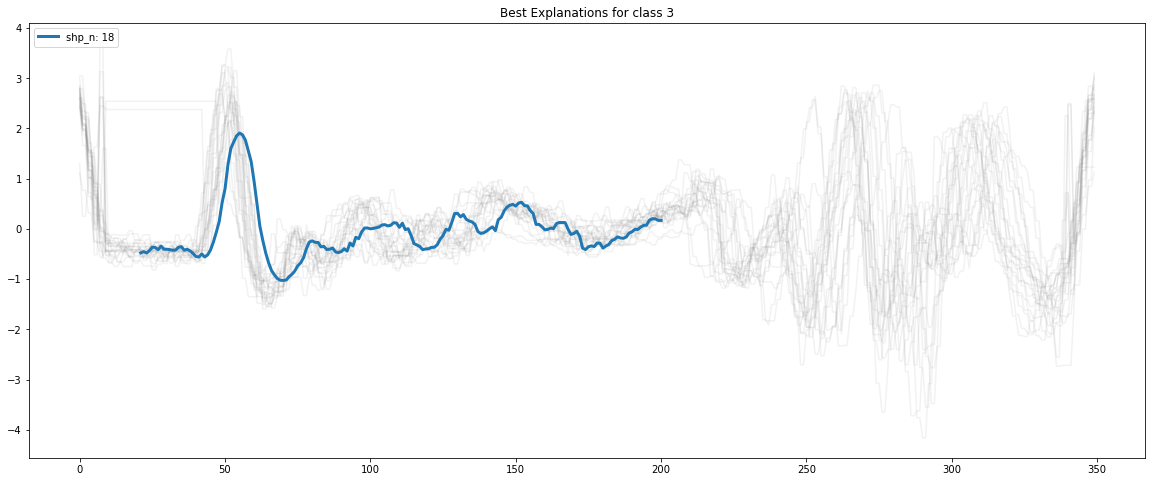

In [428]:
def plot_class_and_shapelets_2(y_class, ts_per_class, X_val,shp):
    pyplot.rcParams["figure.figsize"] = (20,8)
    pyplot.title(f"Best Explanations for class {y_class}")
    for ts in ts_per_class:
        pyplot.plot(X_val[ts].flatten(), color="grey", alpha=0.1)
        
    for sp in shp: 

        shp_n = sp
        shp_n = shapelets_Lr[shp_n]
        shp_n = filterNanFromShapelet(shp_n)
    
        shp_pos_n = np.array([torch_dist_ts_shapelet(X_test[ts],  shp_n, to_cuda=False)[1] for  ts in ts_per_class]).mean()
        shp_pos_n = int(np.round(shp_pos_n))
        padded_shapelet = lead_pad_shapelet(shp_n,shp_pos_n)
        pyplot.plot(padded_shapelet, label=f"shp_n: {sp}", linewidth=3)
        plt.legend(loc="upper left")
    pyplot.show()
    
yclass_n = 2
exp_per_ts = 1

#t0 = find_ts_per_class(y_test, 0)
#plot_class_and_shapelets_2(0, t0, X_test,[5, 14])

def plot_shapelets_for_classes(yclasses,bestExp):
    for yclass_n,exp in zip(yclasses,bestExp): 
        cl = find_ts_per_class(y_test,yclass_n)
        plot_class_and_shapelets_2(yclass_n, cl, X_test,exp)
        

#badEx = [[16, 1],[16, 1],[16, 1],[16, 1]]
#beEx = [[5, 14], [6, 13], [11, 9], [18, 2]]
beEx_train_test= [[5], [6], [11, 9], [18]]
plot_shapelets_for_classes(set(y_test), beEx_train_test)

IndexError: index 20 is out of bounds for axis 0 with size 20

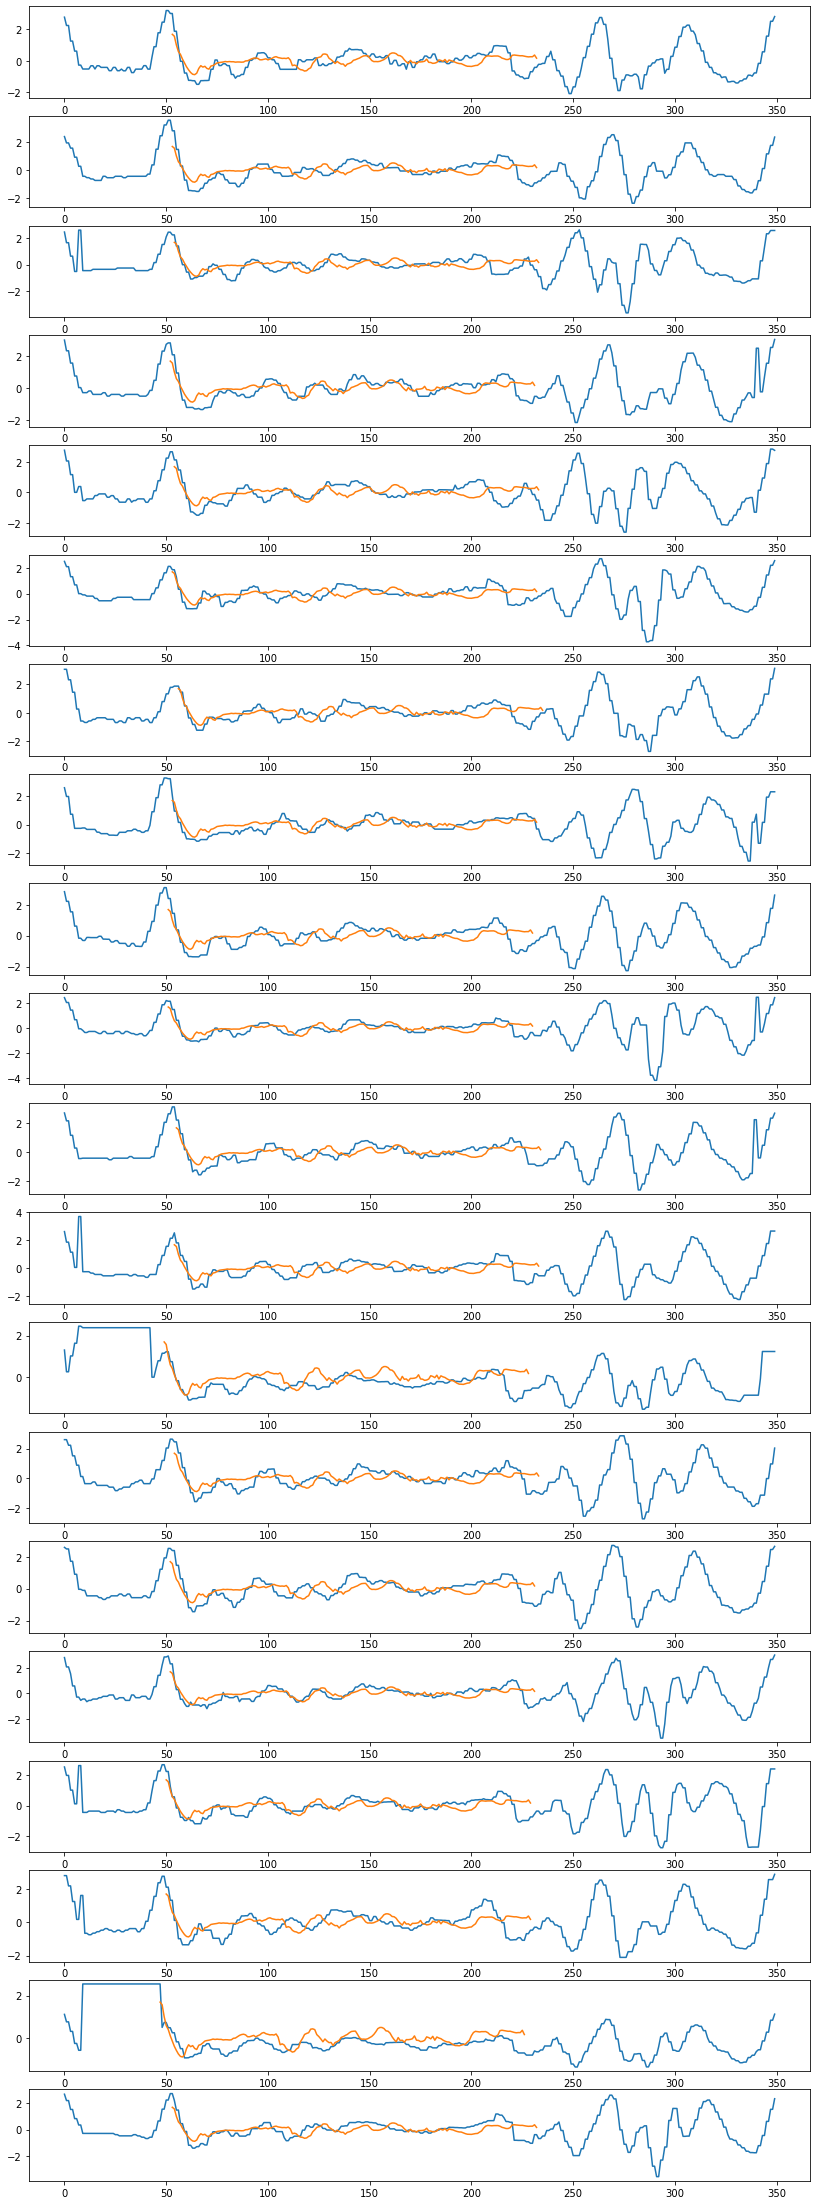

In [453]:
#[22], [25], [18, 28], [9, 1, 15, 16]]
ts_class = find_ts_per_class(y_test,3)
distances = dists_to_shapelet(X_test[ts_class],shapelets_Lr[9], to_cuda=False)
my_shapelet = filterNanFromShapelet(shapelets_Lr[9, 0])

#for ts in ts_class:
#print(torch_dist_ts_shapelet(X_test[ts],  my_shapelet, to_cuda=False))


fig, axes = pyplot.subplots(n_shapelets, 1)
pyplot.rcParams['axes.facecolor'] = 'white'
pyplot.rcParams['savefig.facecolor']='white'
#fig.suptitle(f'Learned Shapelets\nDataset: {dataset}\nLeft: Learning Shapelets (Acc: {test_acc}%, {n_shapelets_ce} Shapelets)\nRight: This work (Acc: {test_acc_Lr}%, {n_shapelets_Lr} Shapelets)')
fig.set_size_inches(14, 2 * n_shapelets)

shapelet_Lr = ""#filterNanFromShapelet(shapelets_Lr[8, 0])
for i,ts in enumerate(ts_class):
    pos = torch_dist_ts_shapelet(X_test[ts],  my_shapelet, to_cuda=False)[1]
    #print(shapelet_Lr, X_test[ts])
    plot_shapelet_on_ts_at_i(my_shapelet, X_test[ts,0],pos, axis=axes[i])
pyplot.tight_layout(rect=[0, 0.03, 1, 0.98])
pyplot.show()





In [159]:
#print(test_df)
#print(test_df.idxmin(axis=1).sort_values())
print(find_ts_per_class(y_test,0))

sv = test_df.idxmin(axis=1).sort_values()

bestMatch = []
prev_value = 0
struc = [[] for _ in range(len(set(y_test)))]

for index, value in sv.items():
    struc[value].append(index)
print(struc)

[68 44 49 36 75 74 81 73 20 10 23  1  4 84]
[[19, 2, 17, 16, 6, 8, 18, 10, 14, 13], [1, 3], [11], [15, 0, 7, 5, 4, 12, 9]]


101
120 120
[0]
Accuracy: 1.0
350


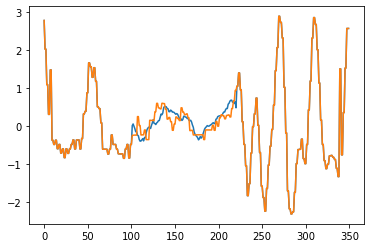

In [246]:
#[[8, 3], [6, 0], [13], [9]]
#[[5, 14], [6, 13], [11, 9], [18, 2]]
import matplotlib.pyplot as plt
tsn = 49
spn = 14
my_shapelet = filterNanFromShapelet(shapelets_Lr[spn, 0])
counter_shapelet = filterNanFromShapelet(shapelets_Lr[spn, 0])
pos = torch_dist_ts_shapelet(X_test[tsn],  my_shapelet, to_cuda=False)[1]
print(pos)
posidx = [i for i in range(pos,pos+len(my_shapelet))]
print(len(posidx), len(my_shapelet))
#print(ts_class,X_train.shape,np.array(y_train[0]))
#eval_accuracy(learning_shapelets_Lr, X_train[0], y_train[0])

d = X_test[tsn].copy()


xmod = d

#zero shapelet
zero_shapelet = np.zeros(180)
rand_shapelet = np.random.rand(180)
#np.put(xmod, posidx, counter_shapelet)
np.put(xmod, posidx, my_shapelet)


#print(xmod == X_test[52])


xt1 = np.expand_dims(np.array(xmod), axis=0)
yt1 = np.expand_dims(np.array(y_test[tsn]), axis=0)

eval_accuracy(learning_shapelets_Lr, xt1, yt1)


plt.plot(xmod.T)
plt.plot(X_test[tsn].T)
print(len(X_test[tsn].T))
#plt.plot(counter_shapelet)

In [272]:
import matplotlib.pyplot as plt
import math
def validate_explanations_for_class(X_test, y_test, y_class, possible_exp, model):
    """
    exp_arr = array with explanations for each class
    """
    def flipped_pred(shapelet,posidx,ts):
        
        xmod = ts.copy()
        pos = [i for i in range(posidx,posidx+len(shapelet))]
        np.put(xmod, pos, shapelet)
        xmod = np.expand_dims(np.array(xmod), axis=0)
        
        """
        plt.plot(np.squeeze(xmod))
        padded_shapelet = lead_pad_shapelet(shapelet,posidx)
        plt.plot(padded_shapelet)
        
        """
        
        predictions = model.predict(xmod)
        if len(predictions.shape) == 2:
            predictions = predictions.argmax(axis=1)
        return int(predictions) != y_class, int(predictions)
        
    tss = find_ts_per_class(y_test,y_class)
    ts_exp = []
    for ts in tss:
        min_dis = math.inf
        best_pos = None
        best_exp = None
        distances = []
        positions = []
        explnt = []
        for exp in possible_exp: 
            shapelet = filterNanFromShapelet(shapelets_Lr[exp,0])
            dis,pos = torch_dist_ts_shapelet(X_test[ts], shapelet, to_cuda=False)
            distances.append(dis)
            positions.append(pos)
            explnt.append(exp)
            """
            if dis < min_dis: 
                min_dis = dis
                best_exp = exp
                best_pos = pos
            """
        rand_int = np.random.randint(0,1) if len(possible_exp) > 1  else 0 
        #print(rand_int,len(possible_exp) > 1)

        ind = np.argsort(distances)[:2]#[rand_int]
        ind = list(ind)
        #print(explnt,ind[0])
        best_exp = explnt[ind[0]]
        best_pos = positions[ind[0]]
        if len(possible_exp) > 1 :
            second_bexp = explnt[ind[1]]
            second_bpos = positions[ind[1]]
        else: 
            second_bexp = None
        shapelet = filterNanFromShapelet(shapelets_Lr[best_exp,0])
        
        tsnr = ts
        ts = X_test[ts]
        
        #Insert shapelets into zero vector
        #zero_vec = np.expand_dims(np.random.randn(len(ts.flatten())), axis=0)
        zero_vec = np.expand_dims(np.zeros(len(ts.flatten())), axis=0)
        pos_rand = np.random.randint(0,350-len(shapelet))
        pseudo_flipped, pred = flipped_pred(shapelet,pos_rand,zero_vec)
        
        
        #Occlude with zeros
        #print(ts.shape)
        zero_shapelet = np.zeros(len(shapelet))
        zero_flipped, zflipped_to = flipped_pred(zero_shapelet,best_pos,ts)
        
        #Occlude with random noise
        rand_shapelet = np.random.rand(len(shapelet))
        rand_flipped, rflipped_to = flipped_pred(rand_shapelet,best_pos,ts)
        

        ts_exp.append([tsnr,best_exp,second_bexp,best_pos,zero_flipped,zflipped_to,rand_flipped,rflipped_to,pred])
    return ts_exp


columns=["TimeSeries","Shapelet Explanation", "Shapelet Explanation2","Pos", "Zero Flip", "Flip to", "Rand Flip", "Flip to", "Shap in Zero Vec"]
exp_class_0 = validate_explanations_for_class(X_test,y_test,0,struc[0],learning_shapelets_Lr)
exp_class_1 = validate_explanations_for_class(X_test,y_test,1,struc[1],learning_shapelets_Lr)
exp_class_2 = validate_explanations_for_class(X_test,y_test,2,struc[2],learning_shapelets_Lr)
exp_class_3 = validate_explanations_for_class(X_test,y_test,3,struc[3],learning_shapelets_Lr)

exp_class_00 = validate_explanations_for_class(X_train,y_train,0,struc[0],learning_shapelets_Lr)
exp_class_11 = validate_explanations_for_class(X_train,y_train,1,struc[1],learning_shapelets_Lr)
exp_class_22 = validate_explanations_for_class(X_train,y_train,2,struc[2],learning_shapelets_Lr)
exp_class_33 = validate_explanations_for_class(X_train,y_train,3,struc[3],learning_shapelets_Lr)


In [282]:
pd.DataFrame(exp_class_33,columns=columns)

,TimeSeries,Shapelet Explanation,Shapelet Explanation2,Pos,Zero Flip,Flip to,Rand Flip,Flip to,Shap in Zero Vec
0,10,9,0,112,False,3,True,1,2
1,7,0,4,96,False,3,False,3,2
2,6,0,4,104,False,3,False,3,2
3,5,0,4,100,False,3,False,3,2
4,20,0,9,102,False,3,False,3,2
